# Nuclei segmentation and extraction of features with Stardist

Python module to extract features from the image tiles with segmentation. The goal is to get a dataset where each row is a tile and each column is a feature


# Import

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import anndata as ad

In [5]:
import tensorflow as tf

2024-06-10 10:53:21.566894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from csbdeep.utils import normalize
from stardist.models import StarDist2D
import squidpy as sq

In [7]:
from PIL import Image
from squidpy.im import ImageContainer
import seaborn as sns
from seaborn import objects as so

In [8]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import Delaunay
from collections import Counter
import math

In [9]:
from sklearn.decomposition import PCA

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Input

## Image 34C

In [6]:
#Image 34C
dpath="/disk2/user/cormey/outputs/Tilted_images/034_RJ.C1"

In [7]:
#Image 34C
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/034_RJ.C1.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
2  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
3  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
4  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed


## Image 34A

In [102]:
#Image 34A
dpath="/disk2/user/cormey/outputs/Tilted_images/034_RJ.A1"

In [103]:
#Image 34A
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/034_RJ.A1.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
2  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
3  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
4  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed


## Image 34B

In [158]:
#Image 34B
dpath="/disk2/user/cormey/outputs/Tilted_images/034_RJ.B1"

In [157]:
#Image 34B
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/034_RJ.B1.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/034_R...     Stroma
2  /disk2/user/cormey/outputs/Tilted_images/034_R...     Stroma
3  /disk2/user/cormey/outputs/Tilted_images/034_R...     Stroma
4  /disk2/user/cormey/outputs/Tilted_images/034_R...     Stroma


## Image 34D

In [138]:
#Image 34D
dpath="/disk2/user/cormey/outputs/Tilted_images/034_RJ.D1"

In [139]:
#Image 34D
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/034_RJ.D1.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor
2  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor
3  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor
4  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor


# Image 34C Big tiles (Scale factor x 2)

In [2]:
#Image 34C
dpath="/disk2/user/cormey/outputs/Tilted_images/big_034_RJ.C1"

In [45]:
#Image 34C
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/big_034_RJ.C1.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/big_0...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/big_0...      Mixed
2  /disk2/user/cormey/outputs/Tilted_images/big_0...      Mixed
3  /disk2/user/cormey/outputs/Tilted_images/big_0...      Mixed
4  /disk2/user/cormey/outputs/Tilted_images/big_0...      Mixed


# Image 34C Big tiles (Scale factor x 4)

In [64]:
#Image 34C
dpath="/disk2/user/cormey/outputs/Tilted_images/big4_034_RJ.C1"

In [65]:
#Image 34C
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/big4_034_RJ.C1.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/big4_...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/big4_...      Mixed
2  /disk2/user/cormey/outputs/Tilted_images/big4_...      Mixed
3  /disk2/user/cormey/outputs/Tilted_images/big4_...      Mixed
4  /disk2/user/cormey/outputs/Tilted_images/big4_...      Mixed


# Output

An AnnData object containing a dataset where each row is a tile and each column is a feature (extracted from the image by segmentation). The AnnData object contains also a obs where you can find pathologist's annotation and the path to each tile. Moreover, you can find the segmentation data processed with a PCA in the obsm part of the AnnData object.

In [66]:
n_img=dpath.split("/")[-1]
output_path="/disk2/user/cormey/outputs/Segmentation_objects/{}.h5ad".format(n_img) #creation of the path to save the outputs
output_path

'/disk2/user/cormey/outputs/Segmentation_objects/big4_034_RJ.C1.h5ad'

# Load models

Stardist has four pre-trained models. In this project, the pretrained 2D_versatile_he model will be used. This model is pre-trained with images from the MoNuSeg dataset (Kumar et al., 2017&2020) and the TNBC dataset (Naylor et al., 2018).
The Kumar dataset contains 30 images from TCGA and over 21,000 nuclei of 7 different organs (6 images of breast tissue) of both benign and diseased tissue samples. (6 images of breast invasive carcinoma).
The Naylor dataset contains 50 images of 11 patients with TNBC. The images have areas with low cellularity in stromal and adipose tissue, but also high cellularity areas in the tumor.

In [14]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


Optional: limit GPU usage.
By default, tensorflow maps all the available memory of both GPUs. Limiting the memory usage still allows the model to run, but takes up less memory on the GPU. Run either option 1 or 2. Option 1: Physical limit how much memory tensorflow can use. Option 2: Allow memory growth. Tensorflow uses a small amount of memory by default and uses more when needed.More info: https://medium.com/ibm-data-ai/memory-hygiene-with-tensorflow-during-model-training-and-deployment-for-inference-45cf49a15688Note: since some functions are not in tensorflow version 2, compat.v1 is added in front

In [69]:
#Option 1
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=17000)])

In [16]:
#Option 2
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

2024-06-10 10:54:33.063977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 640 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
2024-06-10 10:54:33.065103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22991 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5


In [17]:
stardist_model = StarDist2D.from_pretrained("2D_versatile_he")

Found model '2D_versatile_he' for 'StarDist2D'.


2024-06-10 10:54:35.663007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 640 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
2024-06-10 10:54:35.663508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22991 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


# Create functions

 ## Open jpg images as an imagecontainer

In [18]:
def container(path):
    """Function to open jpg files and import them as a squidpy image container. Requires the path to the image as input
    """
    image = Image.open(path)
    imagearray = np.array(image)
    image = sq.im.ImageContainer(imagearray, layer="imagelayer")
    return image

##  Functions for Stardist model

In [19]:
def stardist_2D_versatile_he(image, nms_thresh=0.5, prob_thresh=0.6):
    """Function to initialize the stardist model. Takes an imagecontainer, nms threshold and probability threshold as input.
    First, the image is normalized. Normalization can be done either jointly or separate. Then, the initialized stardist model is 
    loaded.
    """
    axis_norm = (0, 1, 2) #Normalize channels jointly
    image = normalize(image, 1, 99.8, axis=axis_norm)
    model=stardist_model
    labels, _ = model.predict_instances(image, nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

In [20]:
def segmentation(image, imagelayer="imagelayer", channel=None, method=stardist_2D_versatile_he, prob_thresh=0.6, nms_thresh=0.5):
    """Function for segmentation. Takes an imagecontainer as input, which should have an H&E-stained image in its "imagelayer".
    By default, this function uses stardist_2D_versatile_he, but other segmentation methods such as watershed can also be used.
    The probability threshold and NMS threshold are set to None by default, to use the default values of the pretrained stardist 
    model which are set to 0.692478 and 0.3, respectively. 
    """
    sq.im.segment(
        img = image,
        layer = imagelayer,
        channel = channel,
        method = method,
        layer_added = "segmentation_stardist",
        prob_thresh = prob_thresh, 
        nms_thresh = nms_thresh
    )

## Extract the barcode from a tilename

In [21]:
def find_barcode(path):
    """Isolate the spot barcode from a filename/path
    """
    split_list = path.split("_")
    barcode = "No barcode found"
    for part in split_list:
        if len(part) == 18 and part.endswith("-1"):
            barcode = part
            break
    
    return barcode

##  Measure features in segmented images

In [22]:
def measure_features(imagecontainer):
    """Takes an imagecontainer with 2 layers (imagelayer and segmentation_stardist) as input and calculates features.  
    """
    features = imagecontainer.features_segmentation(
        label_layer="segmentation_stardist",
        intensity_layer = "imagelayer",
        feature_name="segmented",
        channels=None,
        props=["label","area", "bbox_area", "convex_area", "eccentricity", "equivalent_diameter", "euler_number","extent", 
               "feret_diameter_max", "major_axis_length", "minor_axis_length", "orientation", "perimeter", "solidity"]
    )
    return features

# Test on one tiles

In [23]:
image1=container("/disk2/user/cormey/outputs/Tilted_images/034_RJ.C1/tissue_1111_ATACGTACTTAGCCAC-1_034_RJ.C1.jpg")

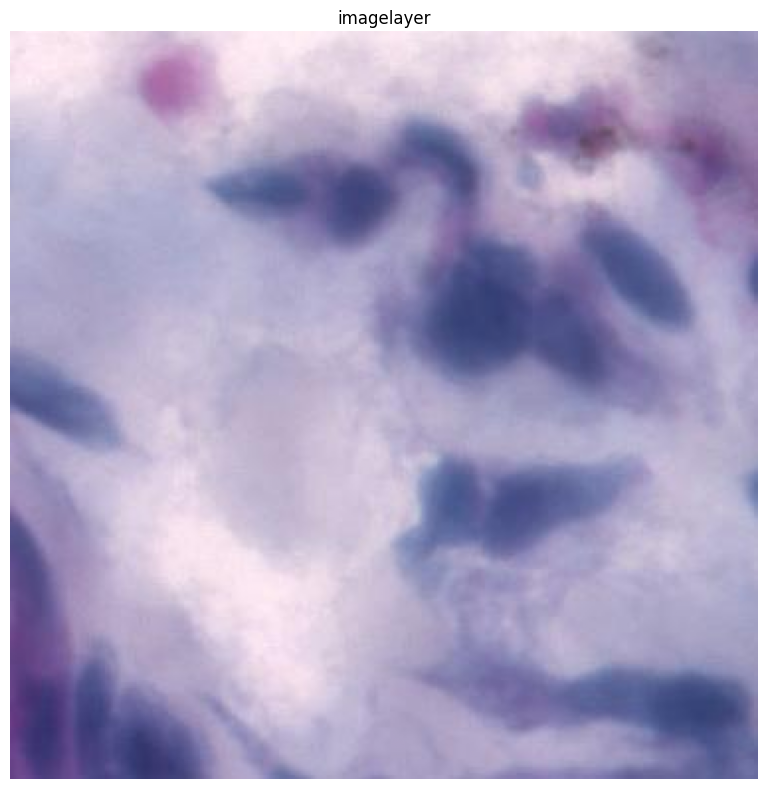

In [24]:
image1.show("imagelayer")

In [25]:
segmentation(image1)

I0000 00:00:1718009695.641779 2313523 service.cc:145] XLA service 0x7f01e00048c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718009695.641862 2313523 service.cc:153]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1718009695.641868 2313523 service.cc:153]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2024-06-10 10:54:55.966567: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-10 10:54:56.152768: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-10 10:54:56.722051: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 548.16MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains i

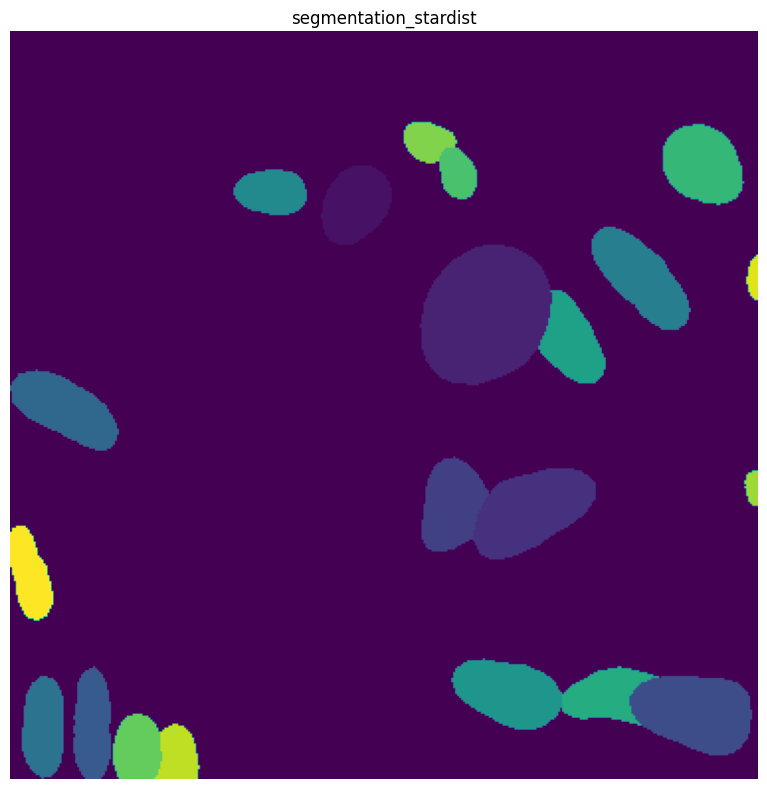

In [27]:
image1.show("segmentation_stardist")

In [28]:
measure_features(image1)

{'segmented_label': 21,
 'segmented_area_mean': 1062.4285714285713,
 'segmented_area_std': 760.5081992249889,
 'segmented_bbox_area_mean': 1507.4761904761904,
 'segmented_bbox_area_std': 1052.84750485563,
 'segmented_convex_area_mean': 1110.095238095238,
 'segmented_convex_area_std': 771.0584503050648,
 'segmented_eccentricity_mean': 0.800178972259132,
 'segmented_eccentricity_std': 0.11526821853344002,
 'segmented_equivalent_diameter_mean': 34.53969913399052,
 'segmented_equivalent_diameter_std': 12.638641316722245,
 'segmented_euler_number_mean': 1.0,
 'segmented_euler_number_std': 0.0,
 'segmented_extent_mean': 0.7207487072597457,
 'segmented_extent_std': 0.08162572889804487,
 'segmented_feret_diameter_max_mean': 47.56795396170137,
 'segmented_feret_diameter_max_std': 15.571776780057391,
 'segmented_major_axis_length_mean': 46.89260356649769,
 'segmented_major_axis_length_std': 15.78568341879693,
 'segmented_minor_axis_length_mean': 26.460288560208657,
 'segmented_minor_axis_length_

# Function to run segmentation and feature extraction on each tile

In [29]:
def f_segmentation(path):

    #Stock the tile in a image container
    imageC=container(path)

    #Segment the image
    segmentation(imageC)

    #Extract features
    features=measure_features(imageC)
    features['path']= row[0]  # path
    features['annotation']= row[1]  # annotation

    # Convert scalar values in features to lists
    features = {key: [value] for key, value in features.items()}

    df=pd.DataFrame(features)
    
    return df

In [30]:
f_segmentation("/disk2/user/cormey/outputs/Tilted_images/034_RJ.C1/tissue_1111_ATACGTACTTAGCCAC-1_034_RJ.C1.jpg")

NameError: name 'row' is not defined

# Creation of an anndata object which combined all the dataframe of each tile

## Creation of a dataframe

In [70]:
features_list = []
list_dataframes = []
for index, row in df_annot.iterrows(): #For all the tiles in the image
    df=f_segmentation(row[0]) #Process a stardist segmentation
                             #Extract the features of all the segmented areas and stock them in a dataset
    list_dataframes.append(df) #Add the dataset in a list
    
# Combine all DataFrames in one
combined_df2 = pd.concat(list_dataframes, keys=range(len(list_dataframes)), names=['tiles', 'region'])

4219707711.py (4): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2024-06-10 12:59:35.798599: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-06-10 12:59:35.830525: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.57 = (f

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/disk2/user/cormey/miniconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/disk2/user/cormey/miniconda3/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/disk2/user/cormey/miniconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_30628/4219707711.py", line 4, in <module>

  File "/tmp/ipykernel_30628/3504764167.py", line 7, in f_segmentation

  File "/tmp/ipykernel_30628/2054774712.py", line 7, in segmentation

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/squidpy/im/_segment.py", line 340, in segment

  File "/disk2/user/cormey/miniconda3/lib/python3.12/functools.py", line 946, in _method

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/squidpy/im/_segment.py", line 166, in _

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/squidpy/im/_container.py", line 1214, in apply

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/squidpy/im/_container.py", line 1185, in apply_func

  File "/disk2/user/cormey/miniconda3/lib/python3.12/functools.py", line 946, in _method

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/squidpy/im/_segment.py", line 104, in _

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/squidpy/im/_segment.py", line 257, in _segment

  File "/tmp/ipykernel_30628/2899021006.py", line 9, in stardist_2D_versatile_he

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/stardist/models/base.py", line 788, in predict_instances

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/stardist/models/base.py", line 740, in _predict_instances_generator

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/stardist/models/base.py", line 603, in _predict_sparse_generator

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/stardist/models/base.py", line 409, in predict_direct

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 504, in predict

  File "/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 204, in one_step_on_data_distributed

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.57 = (f32[1,32,3024,3024]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,3024,3024]{3,2,1,0} %transpose.42, f32[32,3,3,3]{3,2,1,0} %transpose.43, f32[32]{0} %arg2.3), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_1/convolution" source_file="/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16780672 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_110697]

In [71]:
#Clean lignes where there is no data (tiles without any segmented area found)
combined_df2 = combined_df2.dropna()

In [72]:
#Overview on df and combined df

In [73]:
print(combined_df2)

              segmented_label  segmented_area_mean  segmented_area_std  \
tiles region                                                             
0     0                    14          1635.357143         1101.338900   
1     0                    27          1622.740741          655.430850   
2     0                    59           880.288136          433.753544   
3     0                    24          1009.625000          800.080767   
4     0                    53           935.660377          517.323954   
...                       ...                  ...                 ...   
2056  0                    30          1012.833333          672.708361   
2057  0                    25           838.800000          510.760531   
2058  0                    47           848.638298          463.071541   
2059  0                   101           847.811881          408.074462   
2060  0                    70           940.485714          539.877413   

              segmented_bbox_area_mea

In [74]:
print(len(combined_df2))

2061


## Creation of an anndata object

In [75]:
#Reinitialisation of the index of the combined DataFrame
combined_df_reset = combined_df2.reset_index()

# Separate features and annotations
X = combined_df_reset.drop(columns=['path', 'annotation'])
obs = combined_df_reset[['path', 'annotation']]

# Create AnnData object
adata = ad.AnnData(X=X.values, obs=obs)

#Delete first two columns with nothing in them, and the centroid column
cols_to_remove = [0, 1]
cols_to_keep = [i for i in range(adata.X.shape[1]) if i not in cols_to_remove]
adata._inplace_subset_var(cols_to_keep)


#Rename each column of the matrix X
adata.var_names = [
    'segmented_label','segmented_area_mean','segmented_area_std','segmented_bbox_area_mean','segmented_bbox_area_std','segmented_convex_area_mean',
    'segmented_convex_area_std','segmented_eccentricity_mean','segmented_eccentricity_std','segmented_equivalent_diameter_mean',
    'segmented_equivalent_diameter_std','segmented_euler_number_mean','segmented_euler_number_std','segmented_extent_mean','segmented_extent_std',
    'segmented_feret_diameter_max_mean','segmented_feret_diameter_max_std','segmented_major_axis_length_mean','segmented_major_axis_length_std',
    'segmented_minor_axis_length_mean','segmented_minor_axis_length_std','segmented_orientation_mean','segmented_orientation_std',
    'segmented_perimeter_mean','segmented_perimeter_std','segmented_solidity_mean','segmented_solidity_std'
]

# Display an overview of the data
print(adata)

AnnData object with n_obs × n_vars = 2061 × 27
    obs: 'path', 'annotation'


aligned_df.py (67): Transforming to str index.


In [76]:
#Overview of the anndata object

In [77]:
adata.obs.head()

,path,annotation
0,/disk2/user/cormey/outputs/Tilted_images/big_0...,Mixed
1,/disk2/user/cormey/outputs/Tilted_images/big_0...,Mixed
2,/disk2/user/cormey/outputs/Tilted_images/big_0...,Mixed
3,/disk2/user/cormey/outputs/Tilted_images/big_0...,Mixed
4,/disk2/user/cormey/outputs/Tilted_images/big_0...,Mixed


In [78]:
adata.var.head()

""
segmented_label
segmented_area_mean
segmented_area_std
segmented_bbox_area_mean
segmented_bbox_area_std


In [79]:
print(adata.X[:10, :20])

[[1.40000000e+01 1.63535714e+03 1.10133890e+03 2.14000000e+03
  1.44908986e+03 1.67592857e+03 1.11649819e+03 6.75825087e-01
  1.76525854e-01 4.32581317e+01 1.45236163e+01 1.00000000e+00
  0.00000000e+00 7.61347302e-01 3.84012151e-02 5.31361761e+01
  1.45765346e+01 5.21730878e+01 1.46446484e+01 3.69679813e+01]
 [2.70000000e+01 1.62274074e+03 6.55430850e+02 2.17681481e+03
  8.63765102e+02 1.66751852e+03 6.60010963e+02 6.22437130e-01
  1.69725708e-01 4.45011880e+01 9.26185460e+00 1.00000000e+00
  0.00000000e+00 7.43776638e-01 5.98466597e-02 5.30698645e+01
  1.11087485e+01 5.19998568e+01 1.14564201e+01 3.87190618e+01]
 [5.90000000e+01 8.80288136e+02 4.33753544e+02 1.24145763e+03
  6.27661150e+02 9.14915254e+02 4.48124313e+02 7.25054489e-01
  1.47050341e-01 3.25966327e+01 7.63395071e+00 1.00000000e+00
  0.00000000e+00 7.22632858e-01 7.48545038e-02 4.22802627e+01
  1.14643027e+01 4.16203384e+01 1.17528481e+01 2.62406229e+01]
 [2.40000000e+01 1.00962500e+03 8.00080767e+02 1.37416667e+03
  1.0

In [80]:
print(adata.obs.columns)

Index(['path', 'annotation'], dtype='object')


In [81]:
print(adata.var_names)

Index(['segmented_label', 'segmented_area_mean', 'segmented_area_std',
       'segmented_bbox_area_mean', 'segmented_bbox_area_std',
       'segmented_convex_area_mean', 'segmented_convex_area_std',
       'segmented_eccentricity_mean', 'segmented_eccentricity_std',
       'segmented_equivalent_diameter_mean',
       'segmented_equivalent_diameter_std', 'segmented_euler_number_mean',
       'segmented_euler_number_std', 'segmented_extent_mean',
       'segmented_extent_std', 'segmented_feret_diameter_max_mean',
       'segmented_feret_diameter_max_std', 'segmented_major_axis_length_mean',
       'segmented_major_axis_length_std', 'segmented_minor_axis_length_mean',
       'segmented_minor_axis_length_std', 'segmented_orientation_mean',
       'segmented_orientation_std', 'segmented_perimeter_mean',
       'segmented_perimeter_std', 'segmented_solidity_mean',
       'segmented_solidity_std'],
      dtype='object')


In [82]:
#Performing a PCA to reduce the number of features while keeping important informations
# Extract the matrix X de of the AnnData object
X = adata.X

# Create an PCA object with the number of wanted principal componants
pca = PCA(n_components=5)  # 5 PC

# Perform the PCA on the matrix X
reduced_features = pca.fit_transform(X)

# Add results to the AnnData object
adata.obsm['X_pca'] = reduced_features

# Check the results
print("Shape of reduced features:", reduced_features.shape)
print("PCA results added to adata.obsm['X_pca']")

Shape of reduced features: (2061, 5)
PCA results added to adata.obsm['X_pca']


# Save the AnnData object

In [83]:
adata.write_h5ad(output_path)